#Demo de TF-Agents para ordenar elmentos de una lista usando DQN:


0) Preparar el ambiente:

In [ ]:
#@title Instalar Paquete de TF-Agents
!pip install -q tf-agents
print("TF-Agentes instalado.")

TF-Agentes instalado.


In [ ]:
#@title Cargar Librerías
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint
from sklearn import preprocessing
import copy

from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment

from tf_agents.environments import utils
from tf_agents.specs import array_spec

from tf_agents.policies import random_tf_policy

from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

import os
from tf_agents.policies import policy_saver

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")

Librerías cargadas.


1) Establecer las clases sobre el Problema a resolver:

In [ ]:
#@title Definir las primitivas a usar para ordenar la lista

# intercambia valores de pos1 con pos2 
def intercambiar(lista, pos1, pos2):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (pos1 < 0) or (pos1 >= len(lista)):
    if (pos1 < 0):
      pos1 = 0
    else:
      pos1 =  len(lista) - 1
  if (pos2 < 0) or (pos2 >= len(lista)):
    if (pos2 < 0):
      pos2 = 0
    else:
      pos2 =  len(lista) - 1
  # chequea que no sean las mismas posiciones
  if pos1 == pos2:
    return lista
  else:    
    # realiza el intercambio
    lista[pos1], lista[pos2] = lista[pos2], lista[pos1]
    return lista

# mueve el valor de posAnt a posNueva
def mover(lista, posAnt, posNueva):
  # chequea que las posiciones no se encuentran fuera de la lista
  if (posAnt < 0) or (posAnt >= len(lista)):
    if (posAnt < 0):
      posAnt = 0
    else:
      posAnt =  len(lista) - 1
  if (posNueva < 0) or (posNueva >= len(lista)):
    if (posNueva < 0):
      posNueva = 0
    else:
      posNueva =  len(lista) - 1
  # chequea que no sean las mismas posiciones
  if posAnt == posNueva:
    return lista
  else:    
    # realiza el intercambio
    lista.insert(posNueva, lista.pop(posAnt))
    return lista

# función auxiliar para contar la cantidad de desordenados
# (debe ser de menor a mayor)
def contarDesordenados(lista):  
  cantError = 0
  if len(lista) > 0:
    i = 0 
    while i < len(lista):
      ant = lista[i]
      j = i + 1
      while j < len(lista):
        actual = lista[j]
        if actual < ant:
          cantError = cantError + 1
        j = j + 1      
      i = i + 1
  return cantError

# variable auxiliar para determinar máximo de acciones a probar antes de abortar
POSIBLES_ACCIONES_DESC = [ "mover", "intercambiar" ]
POSIBLES_ACCIONES = [ mover,  intercambiar ]

print("Primitivas de acciones definidas: ", POSIBLES_ACCIONES_DESC)

Primitivas de acciones definidas:  ['mover', 'intercambiar']


In [ ]:
#@title Definir Entorno del Problema 

# parámetros generales
MAX_ITERACIONES_REALIZAR = 100
MAX_ITERACIONES_ACCIONES_IGUALES = 4
TAMANIO_MINIMO_LISTA = 3
TAMANIO_MAXIMO_LISTA = 10
MAXIMO_VALOR_ACTION = ((len(POSIBLES_ACCIONES)-1)*100) + (TAMANIO_MAXIMO_LISTA-1) * 10) + (TAMANIO_MAXIMO_LISTA-1)


def parsearAccion(action):
  # como DQN sólo permite 1 action numérica
  # esta función se ocupa de parsearla para determinar:
  #    tipo de acción
  #    param1
  #    param2
  aux = action
  idAccion = aux // 100
  aux = aux - idAccion * 100
  param1 = aux // 10
  aux = aux - param1 * 10
  param2 = aux
  #print(action, idAccion, param1, param2)
  return idAccion, param1, param2

# Un entorno que represente el juego podría verse así:
class OrdenarListasEnv(py_environment.PyEnvironment):

  def __init__(self, reGenerarReset=True):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=MAXIMO_VALOR_ACTION, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(TAMANIO_MAXIMO_LISTA,), dtype=np.float32, name='observation')      
    self._state = 0
    self._antAction = -1
    self._episode_ended = False
    self._reGenerarListaReset = reGenerarReset
    if self._reGenerarListaReset:
      # inicializa vacía porque se define en el reset
      self._listaOriginal = []
    else:
      # la lista se define sólo al principio, luego se vuelve a desordenar
      self._listaOriginal = self.crearLista()
    self._lista = []

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones   
    return self._observation_spec

  def render(self, mode = 'human'):
    # devuelve la lista para mostsrar
    return np.array(self._lista, dtype=np.int32)

  def _reset(self):
    # resetea el entorno
    if self._reGenerarListaReset:
      # cada vez que se reseta, se define la lista
      self._listaOriginal = self.crearLista()
    # siempre la lista de trabajo se copia de la original
    self._lista = copy.deepcopy( self._listaOriginal ) 
    # actualiza el estado considerando cantidad de ordenados
    self.actualizarEstado()
    self._cantIteraciones = 0
    self._episode_ended = False
    self._antAction = []
    return ts.restart(self.devolverObsActual())

  def crearLista(self):
    # genera los valores de las listas al azar
    cantElemRnd = randint(TAMANIO_MINIMO_LISTA, TAMANIO_MAXIMO_LISTA)
    #cantElemRnd = TAMANIO_MAXIMO_LISTA
    lista = []
    for j in range(cantElemRnd): 
      lista.append( randint(-99, 99) )
    return lista

  def actualizarEstado(self):
    # actualiza el valor del estado del entorno
    # teniendo en cuenta la cantidad de errores negativos
    self._state = - contarDesordenados(self._lista)
    return self._state

  def devolverObsActual(self):
    # devuelve valores para la observación actual
    # los valores de la lista (rellenando con cero)
    # para que el agente sepa el estado real del entorno
    res = []
    res.extend( self._lista )
    val = 100
    while (len(res) < TAMANIO_MAXIMO_LISTA):
      res.append( val )
      val = val + 1
    # nota: para DQN parece ser que conviene 
    # normalizar los valores para que sean más homogeneos 
    # y no demasiado dispares entre sí 
    # (sino genera un 'loss' demasiado grande)
    r = (res - np.min(res)) / (np.max(res) - np.min(res))
    return  np.array([round(v,3) for v in r], dtype=np.float32)

  def _step(self, action):
    # aplica una acción sobre el entorno
    
    if self._episode_ended:
      # si el entorno está finalizado, lo resetea
      return self.reset()

    # actualiza cantidad de interacciones 
    self._cantIteraciones = self._cantIteraciones - 1

    # parsea la accion para determinar acción con sus parámetros
    idAccion, param1, param2 = parsearAccion(action)

    # si es un id de acción válida
    if idAccion >= 0 and idAccion < len(POSIBLES_ACCIONES):
      # aplica la acción correspondiente en cada lista
      # y calculando la cantidad de desordenados como error
      self._lista = POSIBLES_ACCIONES[idAccion](self._lista, param1, param2)
      
      # actualiza el estado con la cantidad de valores correctos
      self.actualizarEstado()

      # controla que no sea una acción repetida
      # de forma que si empieza a repetir más de una cantidad máxima
      # finaliza la operatoria
      i = 0
      cantActionIguales = 0 
      while i < len(self._antAction):
        if self._antAction[i] == action:
          cantActionIguales = cantActionIguales + 1
        i = i + 1             
      # siempre mantiene 3 (saca la más vieja)
      # y agrega la nueva
      if len(self._antAction) >= MAX_ITERACIONES_ACCIONES_IGUALES:
        self._antAction.pop( 0 )
      self._antAction.append( action )

    # determina si debe finalizar o no
    if (self._state == 0) or (abs(self._cantIteraciones) >= abs(MAX_ITERACIONES_REALIZAR)) or (cantActionIguales >= MAX_ITERACIONES_ACCIONES_IGUALES):
      # si está todo ordenado 
      # o si la cantidad de iteraciones llega al límite
      # o se repitió muchas veces la misma action
      # fuerza que finaliza
      self._episode_ended = True

    if self._episode_ended:
      # si finaliza
      # devuelve el reward (siempre se maximiza):
      # si logra ordenar
      # se calcula penalizando la cantidad de iteraciones 
      if (self._state == 0):
        reward = MAX_ITERACIONES_REALIZAR + self._cantIteraciones
      else:
        reward = self._state
      return ts.termination(self.devolverObsActual(), reward)
    else:
      # si no finaliza
      reward = self._state
      return ts.transition(
         self.devolverObsActual(), reward=self._state, discount=0.9)
         # notar que no se usa discount=1.0 porque sino genera problema de 'loss' muy grande

print("\nEntorno del Problema definido.")

# Definir entornos de entrenamiento y de evaluación
# (ambos con lista que se cambia cada vez que se resetea)
train_py_env = OrdenarListasEnv(True)
eval_py_env = OrdenarListasEnv(True)

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("\nEntornos de entrenamiento y prueba definidos. ")

# definir simulador para probar el entorno
def SimularEntorno(env, policy, titulo, mostrarDetalle=True):
    print("\n** ", titulo, "**")                   
    # muesta estado inicial
    time_step = env.reset()      
    #ob = time_step.observation.numpy()[0]
    if mostrarDetalle:
      print(" Ini: [", time_step, "]")    
    print(" Lista Inicial = ", env.pyenv.render()[0] )
    j = 1
    while not time_step.is_last():
      # la política determina la acción a realizar
      action_step = policy.action(time_step)
      time_step = env.step(action_step.action)
      # recupera la observación y muestra el nuevo estado 
      ac = action_step.action.numpy()[0]
      idAccion, param1, param2 = parsearAccion(ac)
      r = time_step.reward.numpy()[0]
      ##ob = time_step.observation.numpy()[0]
      descAccion = "acción " +  POSIBLES_ACCIONES_DESC[ idAccion ] + "(" + str(param1) + "," + str(param2) + ")"
      if mostrarDetalle:
        print("  #", j, ":", descAccion, "-> Estado/Reward ", r, "[", time_step, ",", action_step, "]")
      else:
        print("  #", j, ":", descAccion, "-> Estado/Reward ", r)
      ### print("    Lista = ", env.pyenv.render()[0] )
      j = j + 1
    # muestra estado final
    print(" Recompensa Final = ", r )
    print(" Lista Final = ", env.pyenv.render()[0] )
    return r

print("Simulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = True #@param {type:"boolean"}
if Probar_Entorno:
  SimularEntorno(eval_env, random_policy, "Probando el entorno del problema con política al azar")




Entorno del Problema definido.

Entornos de entrenamiento y prueba definidos. 
Simulador del entorno definido.

**  Probando el entorno del problema con política al azar **
 Ini: [ TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.567, 0.598, 0.278, 0.   , 0.974, 0.979, 0.985, 0.99 , 0.995,
        1.   ]], dtype=float32)>) ]
 Lista Inicial =  [ 21  27 -35 -89]
  # 1 : acción intercambiar(6,5) -> Estado/Reward  -5.0 [ TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-5.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>, observation=<tf.Tensor: shape=(1, 10), dtype=float

2) Establecer clase para el Agente:

In [ ]:
#@title Definir el Agente tipo DQN

##learning_rate = 1e-3  # @param {type:"number"}
##cant_neuronas_ocultas = 100 # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
cant_neuronas_ocultas = "100, 50, 25" # @param {type:"string"}

# Define cantidad de neuronas ocultas para RNA-Q
hidden_layers = []
for val in cant_neuronas_ocultas.split(','):
  if  int(val) < 1:
    hidden_layers.append( 10 )
  else:
    hidden_layers.append( int(val) )
fc_layer_params = tuple(hidden_layers, )

# Define RNA-Q
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

# Define el agente de tipo Q
ag = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

ag.initialize()

# define política para evaluación para el Agente
eval_policy = ag.policy

# define política para recolección de datos para el Agente
collect_policy = ag.collect_policy

print("Agente DQN inicializado. ")

Agente DQN inicializado. 


3) Llevar a cabo el Entrenamiento:

In [ ]:
#@title Definir Métricas para evaluación

# Se usa el promedio de la recompensa (la más común)
# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

print("Métricas definidas.")

Métricas definidas.


In [ ]:
#@title Preparar datos para Entrenamiento

initial_collect_steps =   100# @param {type:"integer"} 
collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 64  # @param {type:"integer"}


# Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = ag.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length)

# Recolecta datos generados al azar
# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

print("\nDatos recolectados.")

# Muestra ejemplo de los datos recolectados
##iter(replay_buffer.as_dataset()).next()

# Preparar los datos recolectados con trajectories de shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
iterator = iter(dataset)
# Muestra ejemplo 
##iterator.next()
print("\nDataset creado.")


Datos recolectados.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.

Dataset creado.


In [ ]:
#@title Entrenar al Agente

cant_ciclos_entrenamiento =  50000# @param {type:"integer"}
log_cada_ciclos = 500  # @param {type:"integer"}
mostar_recompensa_cada = 1000  # @param {type:"integer"}
cant_episodios_evaluacion =  25# @param {type:"integer"}

#  Optimize by wrapping some of the code in a graph using TF function (Optional)
ag.train = common.function(ag.train)

# Reset the train step
ag.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
ar_ciclo = []
ar_returns = []
ar_loss = []

print("\n** Comienza el Entrenamiento **\n")
for _ in range(cant_ciclos_entrenamiento):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, ag.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = ag.train(experience).loss

  step = ag.train_step_counter.numpy()

  if (step == 1) or (step == cant_ciclos_entrenamiento) or (step % log_cada_ciclos == 0):
    print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
    ar_ciclo.append( step )
    ar_loss.append( train_loss )
    avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
    ar_returns.append( avg_return )

    if (step == 1) or (step == cant_ciclos_entrenamiento) or (step % mostar_recompensa_cada == 0):
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

print("\n** Entrenamiento Finalizado **\n")



** Comienza el Entrenamiento **

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1: loss = 561.176
step = 1: Promedio Recompensa = -104.2
step = 500: loss = 37.522
step = 1000: loss = 74.668
step = 1000: Promedio Recompensa = -50.1
step = 1500: loss = 118.469
step = 2000: loss = 125.413
step = 2000: Promedio Recompensa = -134.7
step = 2500: loss = 59.758
step = 3000: loss = 50.443
step = 3000: Promedio Recompensa = -61.3
step = 3500: loss = 157.769
step = 4000: loss = 226.962
step = 4000: Promedio Recompensa = -89.5
step = 4500: loss = 98.120
step = 5000: loss = 97.286
step = 5000: Promedio Recompensa = -38.1
step = 5500: loss = 92.209
step = 6000: loss = 250.842
step = 6000: Promedio Recompensa = -117.2
step = 6500: loss = 86.145
step = 7000: loss = 155.036
step = 7000: Promedio Recompensa = -1

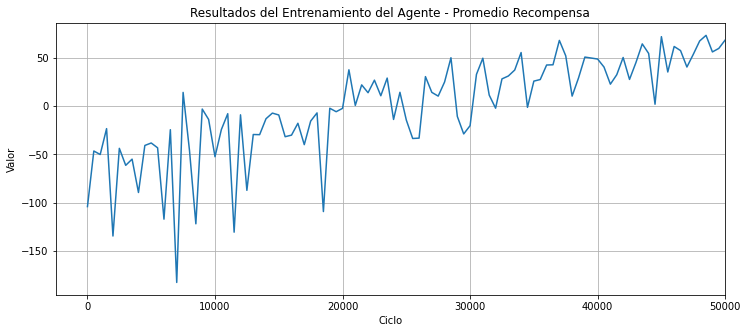

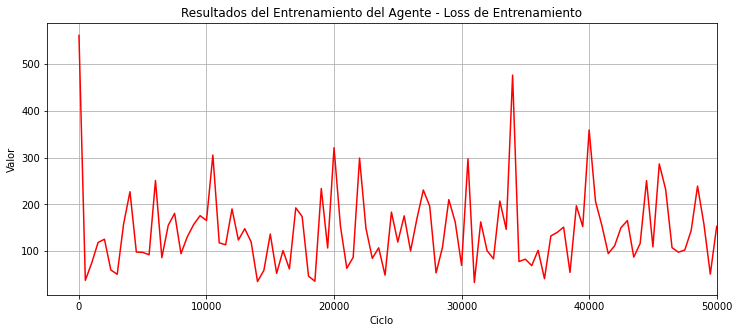

In [ ]:
#@title Mostrar Gráficos del Entrenamiento


plt.figure(figsize=(12,5)) 
plt.plot( ar_ciclo, ar_returns)
plt.title("Resultados del Entrenamiento del Agente - Promedio Recompensa")
#plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
plt.ylabel('Valor')
plt.xlabel('Ciclo')
plt.xlim(right=max(ar_ciclo))   
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5)) 
#plt.plot( ar_ciclo, ar_returns)
plt.plot( ar_ciclo, ar_loss, color="red" )
plt.title("Resultados del Entrenamiento del Agente - Loss de Entrenamiento")
#plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
plt.ylabel('Valor')
plt.xlabel('Ciclo')
plt.xlim(right=max(ar_ciclo))   
plt.grid(True)
plt.show()


4) Cargar / Graba el modelo de las políticas entrenadas:

In [ ]:
#@title Cargar o Guardar el Modelo
# parámetros
directorio_modelo = '/content/gdrive/MyDrive/IA/demoAgentes/Modelos' #@param {type:"string"}
nombre_modelo_grabar = "policy-OrdenarLista" #@param {type:"string"}
accion_realizar = "-" #@param ["-", "Cargar Modelo", "Grabar Modelo"]

# determina lugar donde se guarda el modelo
policy_dir = os.path.join(directorio_modelo, nombre_modelo_grabar)

if accion_realizar != "-":
  # Montar Drive
  from google.colab import drive
  drive.mount('/content/gdrive')
if accion_realizar == "Grabar Modelo":
  # guarda la politica del agente entrenado
  tf_policy_saver = policy_saver.PolicySaver(ag.policy)
  tf_policy_saver.save(policy_dir)
  print("\nPolítica del modelo guardada en ", policy_dir)
elif accion_realizar == "Cargar Modelo":
  # carga la política del modelo
  saved_policy = tf.compat.v2.saved_model.load(policy_dir)
  print("\nPolítica del modelo recuperada de ", policy_dir)

Mounted at /content/gdrive


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/IA/demo Agentes/Modelos/policy-OrdenarLista/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/IA/demo Agentes/Modelos/policy-OrdenarLista/assets



Política del modelo guardada en  /content/gdrive/MyDrive/IA/demo Agentes/Modelos/policy-OrdenarLista


5) Probar entrenamiento comparando resultados:

In [ ]:
#@title Probar el Agente Entrenado contra el Azar
cantidad_probar =  10# @param {type:"integer"}
promAzar = 0
promAgente = 0

# determina política a usar
policy_agente_entrenado = None
if not('ag' in vars() or 'ag' in globals()) or ag is None:
  if not('saved_policy' in vars() or 'saved_policy' in globals()) or saved_policy is None:
    ValueError("No hay política entrenada definida.")
  else:
    policy_agente_entrenado = saved_policy
    print("- Se usa la política recuperada del drive.")
else:
  policy_agente_entrenado = ag.policy
  print("- Se usa la política del modelo entrenado.")

for i in range(cantidad_probar):

  print("\n> Prueba ", i+1, ":")

  # crea nuevo entorno que mantiene la misma lista
  prueba_env =  tf_py_environment.TFPyEnvironment( OrdenarListasEnv(False) )

  # Probar Aleatorio
  valorAzar = SimularEntorno(prueba_env, random_policy, "Resultados Aleatorio", False) 
  promAzar = promAzar + valorAzar

  # Probar Agente Entrenado
  valorAgente = SimularEntorno(prueba_env, policy_agente_entrenado, "Resultados de Agente Entrenado", False) 
  promAgente = promAgente + valorAgente

  # Decide Ganador
  if valorAzar < valorAgente:
    print("\n--> El Agente Entrenado (", valorAgente,") genera MEJOR resultado que el azar (", valorAzar,")")
  else:
    print("\n--> El Agente Entrenado (", valorAgente,") genera PEOR resultado que el azar (", valorAzar,")")

# Decide Ganador General
if cantidad_probar > 0:
  promAgente = promAgente / cantidad_probar
  promAzar = promAzar / cantidad_probar
  print("\n================================================================================================\n")
  if promAzar < promAgente:
    print("= En promedio, el Agente Entrenado (", promAgente,") tiene MEJORES resultado que  el azar (", promAzar,")")
  else:
    print("= En promedio, el Agente Entrenado (", promAgente,") tiene PEORES resultados que el azar (", promAzar,")")
  print("\n================================================================================================\n")

- Se usa la política del modelo entrenado.

> Prueba  1 :

**  Resultados Aleatorio **
 Lista Inicial =  [-88  51  12 -52 -50]
  # 1 : acción intercambiar(2,4) -> Estado/Reward  -4.0
  # 2 : acción intercambiar(4,0) -> Estado/Reward  -9.0
  # 3 : acción intercambiar(6,7) -> Estado/Reward  -9.0
  # 4 : acción mover(6,9) -> Estado/Reward  -9.0
  # 5 : acción mover(7,2) -> Estado/Reward  -7.0
  # 6 : acción mover(4,5) -> Estado/Reward  -7.0
  # 7 : acción intercambiar(1,2) -> Estado/Reward  -6.0
  # 8 : acción mover(7,3) -> Estado/Reward  -5.0
  # 9 : acción mover(0,1) -> Estado/Reward  -4.0
  # 10 : acción mover(9,5) -> Estado/Reward  -4.0
  # 11 : acción mover(1,8) -> Estado/Reward  -3.0
  # 12 : acción intercambiar(4,3) -> Estado/Reward  -4.0
  # 13 : acción intercambiar(5,8) -> Estado/Reward  -4.0
  # 14 : acción mover(4,9) -> Estado/Reward  -4.0
  # 15 : acción intercambiar(8,1) -> Estado/Reward  -1.0
  # 16 : acción mover(1,5) -> Estado/Reward  -2.0
  # 17 : acción mover(1,8) -> Est